In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from CONFIG import *
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)


In [2]:
symbol= 'ACT'
Env = 'pro4'
base_dir = get_base_dir()
df_open = pd.read_csv(f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{Env}/{symbol}_USDT.open.csv')
df_close = pd.read_csv(f'{base_dir}/Obentech/cfdcappData/{symbol}USDT/manager_dc{Env}/{symbol}_USDT.close.csv')



In [3]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown
def parse_start_time(start_str):
    match = re.match(r'^([0-9\-:.\s]+)\s\+0800', str(start_str))
    return pd.Timestamp(match.group(1)) if match else pd.NaT

def clean_timestamp(ts):
    # 提取时间戳的主要部分（去掉CST和m=+部分）
    match = re.match(r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\.\d+)', str(ts))
    if match:
        return match.group(1)
    return ts

df_open = df_open[df_open['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
df_close = df_close[df_close['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
# df_open['start'] = df_open['start'].apply(parse_start_time)
# df_close['start'] = df_close['start'].apply(parse_start_time)
# 转换时间戳为datetime对象
df_open['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['start']])
df_open['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['end']])
df_close['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['start']])
df_close['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['end']])

# 定义方向转换函数
def get_position_multiplier(side):
    if side in ['buy', 'closeShort']:
        return 1
    elif side in ['sell', 'closeLong']:
        return -1
    else:
        return 0
        
for c in ['swap2_deal_amount','swap1_deal_amount']:
    if c in df_close.columns:
        df_close[c] = pd.to_numeric(df_close[c], errors='coerce')
    if c in df_open.columns:
        df_open[c] = pd.to_numeric(df_open[c], errors='coerce')

# 创建包含 Swap1 和 Swap2 的时间序列
all_times_both = pd.concat([
    # Swap1 和 Swap2 开仓
    pd.DataFrame({
        'time': df_open['start'],
        'amount1': df_open['swap1_deal_amount'] * df_open['swap1_side'].map(get_position_multiplier),
        'amount2': df_open['swap2_deal_amount'] * df_open['swap2_side'].map(get_position_multiplier),
        'type': 'open'
    }),
    # Swap1 和 Swap2 平仓
    pd.DataFrame({
        'time': df_close['start'],
        'amount1': df_close['swap1_deal_amount'] * df_close['swap1_side'].map(get_position_multiplier),
        'amount2': df_close['swap2_deal_amount'] * df_close['swap2_side'].map(get_position_multiplier),
        'type': 'close'
    })
]).sort_values('time')

all_times_both['amount1'] = all_times_both['amount1'].astype(float)
all_times_both['amount2'] = all_times_both['amount2'].astype(float)

# 将 time 列转为 pandas 的 datetime 类型（如果还没转的话），再转为时间戳（秒）
all_times_both['time'] = pd.to_datetime(all_times_both['time'])
all_times_both['timestamp'] = all_times_both['time'].astype('int64') // 10**9  # 秒级时间戳

# 计算两个合约的累计持仓
all_times_both['cumulative_position1'] = all_times_both['amount1'].cumsum()
all_times_both['cumulative_position2'] = all_times_both['amount2'].cumsum()

# 用plotly画
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=all_times_both['time'],
    y=all_times_both['cumulative_position1'],
    mode='lines',
    name='Swap1 (BN) Position',
    line=dict(color='#1976D2', width=2.5)
))

fig.add_trace(go.Scatter(
    x=all_times_both['time'],
    y=all_times_both['cumulative_position2'],
    mode='lines',
    name='Swap2 (OKX) Position',
    line=dict(color='#D32F2F', width=2.5, dash='dash')
))

# 填充仓位之间的区域
fig.add_trace(go.Scatter(
    x=pd.concat([all_times_both['time'], all_times_both['time'][::-1]]),
    y=pd.concat([all_times_both['cumulative_position1'], all_times_both['cumulative_position2'][::-1]]),
    fill='toself',
    fillcolor='rgba(128,128,128,0.08)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Position Difference',
    showlegend=True
))

fig.update_layout(
    title=dict(
        text=f'{Env} {symbol} Swap1 vs Swap2 Position Size Over Time',
        font=dict(size=18, family='Arial', color='black'),
        x=0.5
    ),
    xaxis=dict(
        title='Time',
        tickformat='%m-%d<br>%H:%M',
        tickangle=30,
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)',
        type='date'
    ),
    yaxis=dict(
        title='Position Size (Coins)',
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    legend=dict(
        orientation='v',
        x=0.01,
        y=0.99,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.1)',
        borderwidth=1,
        font=dict(size=13)
    ),
    margin=dict(l=60, r=30, t=60, b=60),
    plot_bgcolor='white',
    width=1500,
    height=800
)

fig.show()

# 打印一些基本统计信息
display(Markdown(f"""
**Swap1 统计:**
- 最大持仓量: `{all_times_both['cumulative_position1'].max():.4f}`
- 最小持仓量: `{all_times_both['cumulative_position1'].min():.4f}`
- 平均持仓量: `{all_times_both['cumulative_position1'].mean():.4f}`

**Swap2 统计:**
- 最大持仓量: `{all_times_both['cumulative_position2'].max():.4f}`
- 最小持仓量: `{all_times_both['cumulative_position2'].min():.4f}`
- 平均持仓量: `{all_times_both['cumulative_position2'].mean():.4f}`
"""))

# 检查对称性
position_diff = all_times_both['cumulative_position1'] + all_times_both['cumulative_position2']
display(Markdown(f"""
**仓位对称性检查:**
- 仓位之和的最大偏差: `{position_diff.abs().max():.8f}`
- 仓位之和的平均偏差: `{position_diff.abs().mean():.8f}`
"""))



**Swap1 统计:**
- 最大持仓量: `747321.0000`
- 最小持仓量: `1931.0000`
- 平均持仓量: `406376.5900`

**Swap2 统计:**
- 最大持仓量: `-1931.0000`
- 最小持仓量: `-747321.0000`
- 平均持仓量: `-406376.5900`



**仓位对称性检查:**
- 仓位之和的最大偏差: `0.00000000`
- 仓位之和的平均偏差: `0.00000000`


In [4]:
pip install -U nbformat ipython


   ---------------------------------------- 0.0/621.4 kB ? eta -:--:--
   ---------------------------------------- 621.4/621.4 kB 12.5 MB/s  0:00:00

   ---------------------------------------- 0/8 [fastjsonschema]
   ---------- ----------------------------- 2/8 [attrs]
   ---------- ----------------------------- 2/8 [attrs]
   --------------- ------------------------ 3/8 [referencing]
  Attempting uninstall: ipython
   --------------- ------------------------ 3/8 [referencing]
    Found existing installation: ipython 9.8.0
   --------------- ------------------------ 3/8 [referencing]
    Uninstalling ipython-9.8.0:
   --------------- ------------------------ 3/8 [referencing]
   -------------------- ------------------- 4/8 [ipython]
      Successfully uninstalled ipython-9.8.0
   -------------------- ------------------- 4/8 [ipython]
   -------------------- ------------------- 4/8 [ipython]
   -------------------- ------------------- 4/8 [ipython]
   -------------------- -------------

In [6]:
symbol= 'MOODENG'
Env = 'pro17'
df_open = pd.read_csv(f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{Env}/{symbol}_USDT.open.csv')
df_close = pd.read_csv(f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dc{Env}/{symbol}_USDT.close.csv')


In [8]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import display, Markdown
def parse_start_time(start_str):
    match = re.match(r'^([0-9\-:.\s]+)\s\+0800', str(start_str))
    return pd.Timestamp(match.group(1)) if match else pd.NaT

def clean_timestamp(ts):
    # 提取时间戳的主要部分（去掉CST和m=+部分）
    match = re.match(r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\.\d+)', str(ts))
    if match:
        return match.group(1)
    return ts

df_open = df_open[df_open['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
df_close = df_close[df_close['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
# df_open['start'] = df_open['start'].apply(parse_start_time)
# df_close['start'] = df_close['start'].apply(parse_start_time)
# 转换时间戳为datetime对象
df_open['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['start']])
df_open['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['end']])
df_close['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['start']])
df_close['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['end']])

# 定义方向转换函数
def get_position_multiplier(side):
    if side in ['buy', 'closeShort']:
        return 1
    elif side in ['sell', 'closeLong']:
        return -1
    else:
        return 0
        
for c in ['swap2_deal_amount','swap1_deal_amount']:
    if c in df_close.columns:
        df_close[c] = pd.to_numeric(df_close[c], errors='coerce')
    if c in df_open.columns:
        df_open[c] = pd.to_numeric(df_open[c], errors='coerce')

# 创建包含 Swap1 和 Swap2 的时间序列
all_times_both = pd.concat([
    # Swap1 和 Swap2 开仓
    pd.DataFrame({
        'time': df_open['start'],
        'amount1': df_open['swap1_deal_amount'] * df_open['swap1_side'].map(get_position_multiplier),
        'amount2': df_open['swap2_deal_amount'] * df_open['swap2_side'].map(get_position_multiplier),
        'type': 'open'
    }),
    # Swap1 和 Swap2 平仓
    pd.DataFrame({
        'time': df_close['start'],
        'amount1': df_close['swap1_deal_amount'] * df_close['swap1_side'].map(get_position_multiplier),
        'amount2': df_close['swap2_deal_amount'] * df_close['swap2_side'].map(get_position_multiplier),
        'type': 'close'
    })
]).sort_values('time')

all_times_both['amount1'] = all_times_both['amount1'].astype(float)
all_times_both['amount2'] = all_times_both['amount2'].astype(float)

# 将 time 列转为 pandas 的 datetime 类型（如果还没转的话），再转为时间戳（秒）
all_times_both['time'] = pd.to_datetime(all_times_both['time'])
all_times_both['timestamp'] = all_times_both['time'].astype('int64') // 10**9  # 秒级时间戳

# 计算两个合约的累计持仓
all_times_both['cumulative_position1'] = all_times_both['amount1'].cumsum()
all_times_both['cumulative_position2'] = all_times_both['amount2'].cumsum()

# 用plotly画
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=all_times_both['time'],
    y=all_times_both['cumulative_position1'],
    mode='lines',
    name='Swap1 (BN) Position',
    line=dict(color='#1976D2', width=2.5)
))

fig.add_trace(go.Scatter(
    x=all_times_both['time'],
    y=all_times_both['cumulative_position2'],
    mode='lines',
    name='Swap2 (OKX) Position',
    line=dict(color='#D32F2F', width=2.5, dash='dash')
))

# 填充仓位之间的区域
fig.add_trace(go.Scatter(
    x=pd.concat([all_times_both['time'], all_times_both['time'][::-1]]),
    y=pd.concat([all_times_both['cumulative_position1'], all_times_both['cumulative_position2'][::-1]]),
    fill='toself',
    fillcolor='rgba(128,128,128,0.08)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo='skip',
    name='Position Difference',
    showlegend=True
))

fig.update_layout(
    title=dict(
        text=f'{Env} {symbol} Swap1 vs Swap2 Position Size Over Time',
        font=dict(size=18, family='Arial', color='black'),
        x=0.5
    ),
    xaxis=dict(
        title='Time',
        tickformat='%m-%d<br>%H:%M',
        tickangle=30,
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)',
        type='date'
    ),
    yaxis=dict(
        title='Position Size (Coins)',
        showgrid=True,
        gridcolor='rgba(200,200,200,0.3)'
    ),
    legend=dict(
        orientation='v',
        x=0.01,
        y=0.99,
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.1)',
        borderwidth=1,
        font=dict(size=13)
    ),
    margin=dict(l=60, r=30, t=60, b=60),
    plot_bgcolor='white',
    width=1500,
    height=800
)

fig.show()

# 打印一些基本统计信息
display(Markdown(f"""
**Swap1 统计:**
- 最大持仓量: `{all_times_both['cumulative_position1'].max():.4f}`
- 最小持仓量: `{all_times_both['cumulative_position1'].min():.4f}`
- 平均持仓量: `{all_times_both['cumulative_position1'].mean():.4f}`

**Swap2 统计:**
- 最大持仓量: `{all_times_both['cumulative_position2'].max():.4f}`
- 最小持仓量: `{all_times_both['cumulative_position2'].min():.4f}`
- 平均持仓量: `{all_times_both['cumulative_position2'].mean():.4f}`
"""))

# 检查对称性
position_diff = all_times_both['cumulative_position1'] + all_times_both['cumulative_position2']
display(Markdown(f"""
**仓位对称性检查:**
- 仓位之和的最大偏差: `{position_diff.abs().max():.8f}`
- 仓位之和的平均偏差: `{position_diff.abs().mean():.8f}`
"""))



**Swap1 统计:**
- 最大持仓量: `165840.0000`
- 最小持仓量: `-169580.0000`
- 平均持仓量: `856.0124`

**Swap2 统计:**
- 最大持仓量: `169580.0000`
- 最小持仓量: `-165840.0000`
- 平均持仓量: `-856.0124`



**仓位对称性检查:**
- 仓位之和的最大偏差: `0.00000000`
- 仓位之和的平均偏差: `0.00000000`


In [9]:
import pandas as pd
import numpy as np
import re
import plotly.graph_objs as go

# ---------------------------
# 工具函数：清洗 timestamp
# ---------------------------
def clean_timestamp(ts):
    match = re.match(r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\.\d+)', str(ts))
    return match.group(1) if match else ts

# ---------------------------
# 工具函数：方向 multipler
# ---------------------------
def get_position_multiplier(side):
    if side in ['buy', 'closeShort']:
        return 1
    elif side in ['sell', 'closeLong']:
        return -1
    else:
        return 0

# ======================================================
# 核心函数：给定 df_open, df_close，构造仓位时间序列
# ======================================================
def build_position_df(df_open, df_close, env_name):

    df_open = df_open.copy()
    df_close = df_close.copy()

    # 过滤无效时间
    df_open = df_open[df_open['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]
    df_close = df_close[df_close['start'].astype(str).str.contains(r'\d{4}-\d{2}-\d{2}')]

    # 转成 timestamp
    df_open['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['start']])
    df_open['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['end']])
    df_close['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['start']])
    df_close['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['end']])

    # 数值转换
    for c in ['swap2_deal_amount', 'swap1_deal_amount']:
        if c in df_close.columns:
            df_close[c] = pd.to_numeric(df_close[c], errors='coerce')
        if c in df_open.columns:
            df_open[c] = pd.to_numeric(df_open[c], errors='coerce')

    # 组合开仓和平仓
    all_times = pd.concat([
        pd.DataFrame({
            'time': df_open['start'],
            'amount1': df_open['swap1_deal_amount'] * df_open['swap1_side'].map(get_position_multiplier),
            'amount2': df_open['swap2_deal_amount'] * df_open['swap2_side'].map(get_position_multiplier),
            'type': 'open',
            'env': env_name
        }),
        pd.DataFrame({
            'time': df_close['start'],
            'amount1': df_close['swap1_deal_amount'] * df_close['swap1_side'].map(get_position_multiplier),
            'amount2': df_close['swap2_deal_amount'] * df_close['swap2_side'].map(get_position_multiplier),
            'type': 'close',
            'env': env_name
        })
    ]).sort_values('time')

    all_times['amount1'] = all_times['amount1'].astype(float)
    all_times['amount2'] = all_times['amount2'].astype(float)

    # 累计仓位
    all_times['cumulative_position1'] = all_times['amount1'].cumsum()
    all_times['cumulative_position2'] = all_times['amount2'].cumsum()

    return all_times


# ======================================================
# 读取 pro1 / pro17 两个环境
# ======================================================
symbol = "MOODENG"

# pro17
df_open_17 = pd.read_csv(f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dcpro17/{symbol}_USDT.open.csv')
df_close_17 = pd.read_csv(f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dcpro17/{symbol}_USDT.close.csv')
df17 = build_position_df(df_open_17, df_close_17, 'pro17')

# pro1
df_open_1 = pd.read_csv(f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dcpro1/{symbol}_USDT.open.csv')
df_close_1 = pd.read_csv(f'/Volumes/T7/Obentech/cfdcappData/{symbol}USDT/manager_dcpro1/{symbol}_USDT.close.csv')
df1 = build_position_df(df_open_1, df_close_1, 'pro1')


# ======================================================
# 画图（双环境叠加）
# ======================================================
fig = go.Figure()

# pro1
fig.add_trace(go.Scatter(
    x=df1['time'], y=df1['cumulative_position1'],
    mode='lines', name='pro1 Swap1', line=dict(width=2.5, color='#1565C0')
))
fig.add_trace(go.Scatter(
    x=df1['time'], y=df1['cumulative_position2'],
    mode='lines', name='pro1 Swap2', line=dict(width=2.5, dash='dash', color='#EF5350')
))

# pro17
fig.add_trace(go.Scatter(
    x=df17['time'], y=df17['cumulative_position1'],
    mode='lines', name='pro17 Swap1', line=dict(width=2.5, color='#26A69A')
))
fig.add_trace(go.Scatter(
    x=df17['time'], y=df17['cumulative_position2'],
    mode='lines', name='pro17 Swap2', line=dict(width=2.5, dash='dash', color='#AB47BC')
))

# Layout
fig.update_layout(
    title=f"{symbol} Swap Position Comparison: pro1 vs pro17",
    width=1600, height=800,
    plot_bgcolor='white',
    xaxis=dict(title="Time", tickformat="%m-%d<br>%H:%M"),
    yaxis=dict(title="Position Size (Coins)"),
    legend=dict(
        x=0.01, y=0.99,
        bgcolor='rgba(255,255,255,0.75)',
        bordercolor='rgba(0,0,0,0.2)'
    )
)

fig.show()


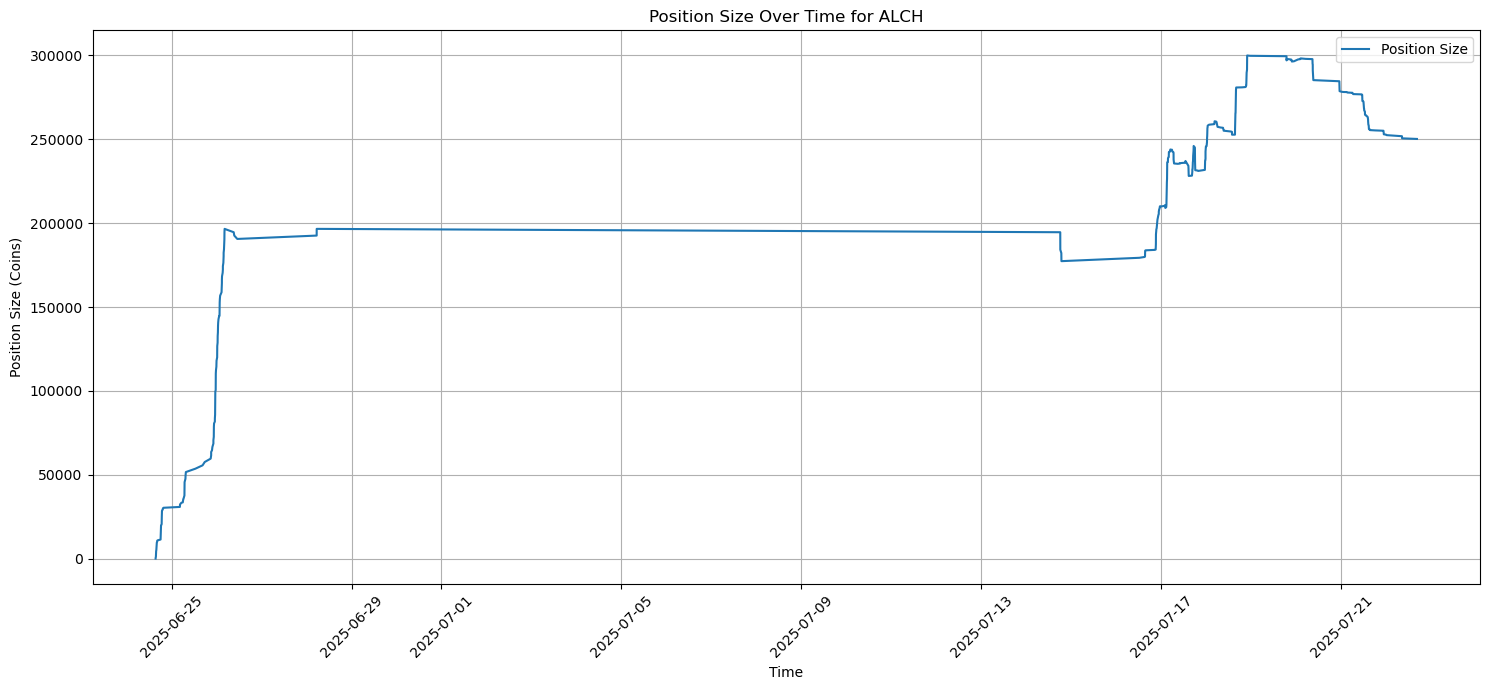

最大持仓量: 299921.00
最小持仓量: 49.00
平均持仓量: 211955.37


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re

# 定义一个函数来清理时间字符串
def clean_timestamp(ts):
    # 提取时间戳的主要部分（去掉CST和m=+部分）
    match = re.match(r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\.\d+)', str(ts))
    if match:
        return match.group(1)
    return ts

# 转换时间戳为datetime对象
df_open['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['start']])
df_open['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_open['end']])
df_close['start'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['start']])
df_close['end'] = pd.to_datetime([clean_timestamp(ts) for ts in df_close['end']])

# 创建时间序列
all_times = pd.concat([
    pd.DataFrame({'time': df_open['start'], 'amount': df_open['swap1_deal_amount'], 'type': 'open'}),
    pd.DataFrame({'time': df_close['start'], 'amount': -df_close['swap1_deal_amount'], 'type': 'close'})
]).sort_values('time')

# 计算累计持仓
all_times['cumulative_position'] = all_times['amount'].cumsum()

# 绘制图形
plt.figure(figsize=(15, 7))
plt.plot(all_times['time'], all_times['cumulative_position'], label='Position Size')
plt.grid(True)
plt.title('Position Size Over Time for ALCH')
plt.xlabel('Time')
plt.ylabel('Position Size (Coins)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print(f"最大持仓量: {all_times['cumulative_position'].max():.2f}")
print(f"最小持仓量: {all_times['cumulative_position'].min():.2f}")
print(f"平均持仓量: {all_times['cumulative_position'].mean():.2f}")


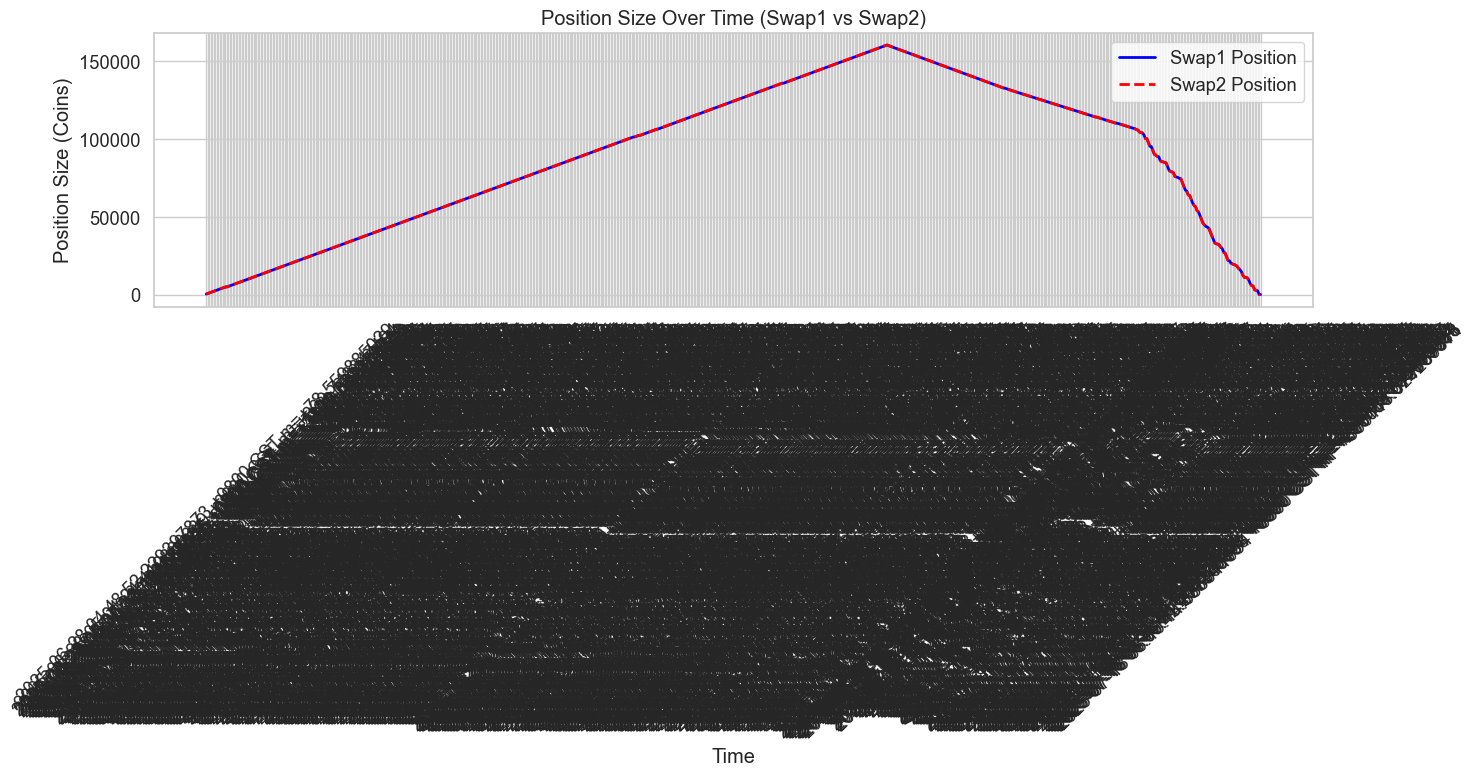

Swap1 统计:
最大持仓量: 160346.0000
最小持仓量: 0.0000
平均持仓量: 89248.8210

Swap2 统计:
最大持仓量: 160360.0000
最小持仓量: 0.0000
平均持仓量: 89256.1538

仓位对称性检查:
仓位之和的最大偏差: 320706.00000000
仓位之和的平均偏差: 178504.97482517


In [13]:
# 创建包含 Swap1 和 Swap2 的时间序列
all_times_both = pd.concat([
    # Swap1 开仓和平仓
    pd.DataFrame({
        'time': df_open['start'],
        'amount1': df_open['swap1_deal_amount'],
        'amount2': df_open['swap2_deal_amount'],
        'type': 'open'
    }),
    pd.DataFrame({
        'time': df_close['start'],
        'amount1': -df_close['swap1_deal_amount'],
        'amount2': -df_close['swap2_deal_amount'],
        'type': 'close'
    })
]).sort_values('time')

# 计算两个合约的累计持仓
all_times_both['cumulative_position1'] = all_times_both['amount1'].cumsum()
all_times_both['cumulative_position2'] = all_times_both['amount2'].cumsum()

# 绘制图形
plt.figure(figsize=(15, 8))

# 画 Swap1 的仓位
plt.plot(all_times_both['time'], all_times_both['cumulative_position1'], 
         label='Swap1 Position', color='blue', linewidth=2)

# 画 Swap2 的仓位
plt.plot(all_times_both['time'], all_times_both['cumulative_position2'], 
         label='Swap2 Position', color='red', linewidth=2, linestyle='--')

plt.grid(True)
plt.title('Position Size Over Time (Swap1 vs Swap2)')
plt.xlabel('Time')
plt.ylabel('Position Size (Coins)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 打印一些基本统计信息
print("Swap1 统计:")
print(f"最大持仓量: {all_times_both['cumulative_position1'].max():.4f}")
print(f"最小持仓量: {all_times_both['cumulative_position1'].min():.4f}")
print(f"平均持仓量: {all_times_both['cumulative_position1'].mean():.4f}")
print("\nSwap2 统计:")
print(f"最大持仓量: {all_times_both['cumulative_position2'].max():.4f}")
print(f"最小持仓量: {all_times_both['cumulative_position2'].min():.4f}")
print(f"平均持仓量: {all_times_both['cumulative_position2'].mean():.4f}")

# 检查对称性
print("\n仓位对称性检查:")
position_diff = all_times_both['cumulative_position1'] + all_times_both['cumulative_position2']
print(f"仓位之和的最大偏差: {position_diff.abs().max():.8f}")
print(f"仓位之和的平均偏差: {position_diff.abs().mean():.8f}")


In [ ]:
merged_df[merged_df['signed_ret_mid_10.0s'] < 0]['slippage'].describe()

count    4.070000e+02
mean    -1.858349e-04
std      2.482849e-04
min     -1.902866e-03
25%     -3.048958e-04
50%     -9.438631e-05
75%      2.987577e-09
max      2.604764e-04
Name: slippage, dtype: float64